Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 10-November-2025

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import itertools
import networkx as nx
import random
import seaborn as sns
import cmocean
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter

C:\Users\Chris\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set parameters 
data_dir = r'Z:/Data/Roadrunner/'
syn_thresh = 5
nt_type_score_thresh = 0.62
nt_inhibitory_effect = ['GABA','GLUT']
shuffle = False # True
n_iterations = 1 # 10000
source_neurons = 'RR' # 'RR' or 'RR_BPN'

In [3]:
# Load connectivity 
df_connectivity = pd.read_csv(data_dir + 'flywire_v783_connections_princeton.csv')
df_connectivity = df_connectivity.rename(columns={"pre_pt_root_id": "pre_root_id", "post_pt_root_id": "post_root_id"}, errors="raise")
    
# Load neuron classifications 
df_class = pd.read_csv(data_dir + 'flywire_v783_classifications.csv')

# Load neurotransmitter information 
df_nt = pd.read_csv(data_dir + 'flywire_v783_neurotransmitters.csv') # neuron.csv

# Load neurons of interest
df_neurons_of_interest = pd.read_csv(data_dir + 'neurons_of_interest.csv')

In [4]:
# Set source neurons
dict_nodes = {}
if source_neurons == 'RR':
    dict_nodes['source_1'] = [df_neurons_of_interest.root_id[df_neurons_of_interest.community_name=='Roadrunner'].tolist()[0]]
    dict_nodes['source_2'] = [df_neurons_of_interest.root_id[df_neurons_of_interest.community_name=='Roadrunner'].tolist()[1]] 
elif source_neurons == 'RR_BPN':
    dict_nodes['source_1'] = df_neurons_of_interest.root_id[df_neurons_of_interest.community_name=='Roadrunner'].tolist() 
    dict_nodes['source_2'] = df_neurons_of_interest.root_id[df_neurons_of_interest.community_name.str.contains('BPN')].tolist()
    
source_nodes = list(itertools.chain(*list(dict_nodes.values())))

In [5]:
# Sum synapses across neuropils
df_connectivity = df_connectivity.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

In [6]:
# Remove connections between neurons smaller than syn_thresh 
df_connectivity = df_connectivity[df_connectivity.syn_count>=syn_thresh]
df_connectivity

,pre_root_id,post_root_id,syn_count
19534377,720575940650935673,720575940640736371,2633
12271389,720575940628069501,720575940633305681,2597
19047742,720575940644702112,720575940625952755,2238
8673520,720575940623475324,720575940627497244,2179
6610920,720575940620975696,720575940624547622,1872
...,...,...,...
10028067,720575940625304328,720575940617934139,5
11,720575940596125868,720575940616986553,5
10028049,720575940625304328,720575940614543015,5
10028042,720575940625304328,720575940613469334,5


In [7]:
# Update source nodes (applying a synapse threshold can remove source IDs from the connectivity dataframe)
source_nodes = [node for node in source_nodes if node in df_connectivity.pre_root_id.unique().tolist()]

In [8]:
# Get all nodes
all_nodes = pd.unique(df_connectivity[['pre_root_id', 'post_root_id']].values.ravel('K')) 

In [9]:
# Build network graph
net = nx.DiGraph() 

# Add nodes
net.add_nodes_from(all_nodes)

# Add edges
for index, row in tqdm(df_connectivity.iterrows(), total=len(df_connectivity)): 
    net.add_edge(df_connectivity["pre_root_id"][index], 
                 df_connectivity["post_root_id"][index], 
                 weight=int(df_connectivity.syn_count[index]))   

100%|█████████████████████████████████████████████████████████████████████| 3732460/3732460 [01:42<00:00, 36425.33it/s]


In [10]:
# Get potential target IDs 
potential_target_nodes = df_class.root_id[df_class.super_class=='descending'].tolist()

# Include only target IDs that are in the synapse-thresholded dataframe
post_root_ids = df_connectivity.post_root_id.unique().tolist()
potential_target_nodes = [node for node in potential_target_nodes if node in post_root_ids]
del post_root_ids

In [11]:
len(potential_target_nodes)

1287

In [12]:
# Find paths from source nodes to target nodes
path_length = 2 # Number of hops
intermediary_nodes = []
target_nodes = []

for source_node in source_nodes:
    for potential_target_node in potential_target_nodes: 
        if nx.has_path(net, source_node, potential_target_node):
            for path in nx.all_simple_paths(net, source_node, potential_target_node, cutoff=path_length):
                if len(path)==2:
                    target_nodes.append(path[-1])
                if len(path)==3:
                    # Exclude connections via source and target nodes
                    if (path[1] not in potential_target_nodes) and (path[1] not in source_nodes): 
                        intermediary_nodes.append(path[1])
                        target_nodes.append(path[-1])
                
intermediary_nodes = list(np.unique(intermediary_nodes)) 
target_nodes = list(np.unique(target_nodes))

In [13]:
# Confirm that no source node is an intermediary node
for i in source_nodes:
    if i in intermediary_nodes:
        print(i)

In [14]:
# Generate trimmed connectivity dataframe
# Remove 2-hop connections through source or target neurons
df_connectivity_trimmed = pd.DataFrame()

df_connectivity_trimmed = pd.concat([df_connectivity_trimmed,
                                     df_connectivity[
                                         ((df_connectivity['pre_root_id'].isin(source_nodes)) & 
                                          (df_connectivity['post_root_id'].isin(intermediary_nodes + target_nodes)))]
                                    ])
df_connectivity_trimmed = pd.concat([df_connectivity_trimmed, 
                                     df_connectivity[
                                         ((df_connectivity['pre_root_id'].isin(intermediary_nodes)) &
                                          (df_connectivity['post_root_id'].isin(target_nodes)))]       
                                    ])

df_connectivity_trimmed

,pre_root_id,post_root_id,syn_count
18268177,720575940639781027,720575940604458668,73
18268287,720575940639781027,720575940618380052,57
16020149,720575940633362145,720575940611246810,56
16020298,720575940633362145,720575940625905848,52
18268294,720575940639781027,720575940619038493,49
...,...,...,...
1973603,720575940612337331,720575940628030440,5
1973648,720575940612337331,720575940629155227,5
1973684,720575940612337331,720575940630346860,5
1973879,720575940612337331,720575940647586948,5


In [15]:
# [print(i) for i in target_nodes if i not in df_connectivity_trimmed.post_root_id.tolist()]

In [16]:
# df_connectivity_trimmed[(df_connectivity_trimmed["pre_root_id"].isin(target_nodes)) & 
#                         (df_connectivity_trimmed["post_root_id"].isin(target_nodes))]

In [17]:
# Get all nodes
nodes = source_nodes + intermediary_nodes + target_nodes

In [18]:
# Generate dataframe with information about each node
index, root_id, nt_type, nt_type_score, super_class, sub_class = [], [], [], [], [], []

node_keys = list(dict_nodes.keys())

for index_node, node in enumerate(nodes):       
    if node in source_nodes:
        super_class_node = "source"
    elif node in intermediary_nodes:
        super_class_node = "intermediary"
    elif node in target_nodes:
        super_class_node = "target"
    else:
        print('Error')
    
    if node in source_nodes: 
        for key in node_keys:
            if node in dict_nodes[key]:
                sub_class_node = key
    else:
        sub_class_node = ""

    nt_type_node = df_nt.nt_type[df_nt.root_id==node].item()
    nt_type_score_node = df_nt.nt_type_score[df_nt.root_id==node].item()
    if pd.isnull(nt_type_node):
        nt_type_node = "unknown"
    elif super_class_node == "intermediary" and nt_type_score_node < nt_type_score_thresh: 
        nt_type_node = "unknown"
        
    index.append(index_node)
    root_id.append(node)
    nt_type.append(nt_type_node)
    nt_type_score.append(nt_type_score_node)
    super_class.append(super_class_node)
    sub_class.append(sub_class_node)
        
        
df_indices = pd.DataFrame()
df_indices["matrix_index"] = index # Note: .index refers to the dataframe index
df_indices["root_id"] = root_id
df_indices["nt_type"] = nt_type
df_indices["nt_type_score"] = nt_type_score
df_indices["super_class"] = super_class
df_indices["sub_class"] = sub_class

In [19]:
# Generate connectivity matrix with output fractions
# Note: This matrix is not an all-to-all adjacency matrix; it only contains 2-hop feedforward connections from source nodes. 

conn_mat_fractional_outputs = np.zeros((len(nodes),len(nodes)))
for index_pre_node, node in enumerate(nodes):
    # Get total number of output synapses of pre node 
    n_outputs = df_connectivity.syn_count[(df_connectivity['pre_root_id'] == node)].sum()
    
    # Get postsynaptic connectivity of pre node in trimmed dataframe
    df = df_connectivity_trimmed[(df_connectivity_trimmed['pre_root_id'] == node)]
    
    for row_index, row in df.iterrows():
        syn_count = row["syn_count"]
        post_node = row["post_root_id"]
        index_post_node = nodes.index(post_node)
        
        conn_mat_fractional_outputs[index_pre_node,index_post_node] += syn_count/n_outputs    

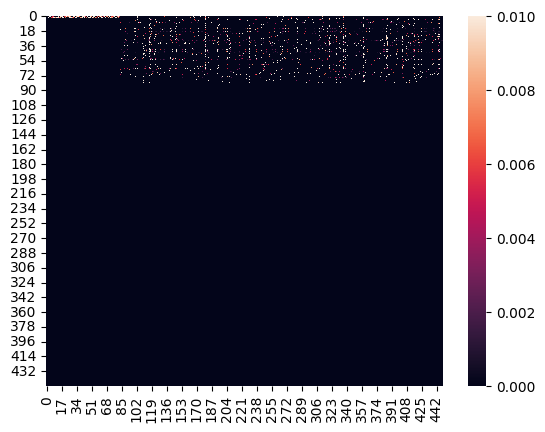

In [20]:
# Plot connectivity matrix
sns.heatmap(conn_mat_fractional_outputs, vmax=0.01);

In [21]:
# Compute output from source nodes onto intermediary and target nodes
# Optional: Shuffle output connections of each source node
shared_source_1_output = []
shared_source_2_output = []

for iteration in tqdm(range(n_iterations)):
    
    # Shuffle output connections of each source node
    conn_mat_shuffled = conn_mat_fractional_outputs.copy()

    if shuffle:
        source_indices = df_indices.index[df_indices["super_class"]=="source"].tolist()
        for index in source_indices:
            # Shuffle output onto intermediary and target nodes
            post_index = list(range(len(source_nodes), len(nodes)))
            random.shuffle(post_index)

            conn_mat_shuffled[index, len(source_nodes):] = conn_mat_shuffled[index, post_index] 
        
        
    # Classify intermediary nodes 
    intermediary_indices = df_indices.index[df_indices["super_class"]=="intermediary"].tolist()
    
    source_1_indices = df_indices.index[df_indices["sub_class"]=="source_1"].tolist()
    source_2_indices = df_indices.index[df_indices["sub_class"]=="source_2"].tolist()

    for index in intermediary_indices:        
        any_source_1_input = any(conn_mat_shuffled[source_1_indices, index]>0)
        any_source_2_input = any(conn_mat_shuffled[source_2_indices, index]>0)

        if any_source_1_input and any_source_2_input:
            sub_class = "intermediary_12"
        elif any_source_1_input and not any_source_2_input: 
            sub_class = "intermediary_1"
        elif any_source_2_input and not any_source_1_input: 
            sub_class = "intermediary_2"
        else:
            sub_class = "intermediary_other"

        df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = sub_class

     # Note: When connections are shuffled, some intermediary nodes are no longer connected to source nodes
     #if "intermediary_other" in df_indices.sub_class.unique().tolist():
     #    print("Some intermediary neurons not connected to source neurons")
    
        
    # Classify target nodes 
    target_indices = df_indices.index[df_indices["super_class"]=="target"].tolist()
    
    source_1_indices = df_indices.index[(df_indices["sub_class"]=="source_1") |
                                        (df_indices["sub_class"]=="intermediary_1")].tolist()
    source_2_indices = df_indices.index[(df_indices["sub_class"]=="source_2") |
                                        (df_indices["sub_class"]=="intermediary_2")].tolist()
    source_12_indices = df_indices.index[df_indices["sub_class"]=="intermediary_12"].tolist()

    for index in target_indices:
        any_source_1_input = any(conn_mat_shuffled[source_1_indices, index]>0)
        any_source_2_input = any(conn_mat_shuffled[source_2_indices, index]>0)
        any_source_12_indices = any(conn_mat_shuffled[source_12_indices, index]>0)

        if (any_source_1_input and any_source_2_input) or any_source_12_indices:
            sub_class = "target_12"
        else: 
            sub_class = "target_other"

        df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = sub_class

    
    # Further classify intermediary nodes 
    target_12_indices = df_indices.index[df_indices["sub_class"]=="target_12"].tolist()

    intermediary_1_indices = df_indices.index[df_indices["sub_class"]=="intermediary_1"].tolist()
    intermediary_2_indices = df_indices.index[df_indices["sub_class"]=="intermediary_2"].tolist()    

    for index in intermediary_1_indices:
        any_shared_output = any(conn_mat_shuffled[index, target_12_indices]>0)    
        if any_shared_output: 
             df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = "intermediary_1_shared"


    for index in intermediary_2_indices:
        any_shared_output = any(conn_mat_shuffled[index, target_12_indices]>0)   
        if any_shared_output: 
             df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = "intermediary_2_shared"
  
                
    # Further classify target nodes 
    target_other_indices = df_indices.index[df_indices["sub_class"]=="target_other"].tolist()

    # Note: After previous classification, intermediary_1 and intermediary_2 do not project to target_12 
    source_1_indices = df_indices.index[(df_indices["sub_class"]=="source_1") |
                                        (df_indices["sub_class"]=="intermediary_1") | 
                                        (df_indices["sub_class"]=="intermediary_1_shared")].tolist()
    source_2_indices = df_indices.index[(df_indices["sub_class"]=="source_2") |
                                        (df_indices["sub_class"]=="intermediary_2") |
                                        (df_indices["sub_class"]=="intermediary_2_shared")].tolist()

    for index in target_other_indices:
        any_source_1_input = any(conn_mat_shuffled[source_1_indices, index]>0)
        any_source_2_input = any(conn_mat_shuffled[source_2_indices, index]>0)

        if any_source_1_input and not any_source_2_input:
            sub_class = "target_1"
        elif any_source_2_input and not any_source_1_input:
            sub_class = "target_2"
        else:
            sub_class = "target_other"

        df_indices.loc[df_indices["matrix_index"]==index, "sub_class"] = sub_class
   
    
    # Get summed relative output of source_1 onto shared pathways
    source_indices = df_indices.index[df_indices["sub_class"]=="source_1"].tolist()
    shared_indices = df_indices.index[(df_indices["sub_class"]=="intermediary_12") |
                                      (df_indices["sub_class"]=="intermediary_1_shared") | 
                                      (df_indices["sub_class"]=="target_12")].tolist()

    shared_source_1_output.append(np.mean(np.sum(conn_mat_shuffled[source_indices,:][:,shared_indices],axis=1)))
    
    # Get summed relative output of source_2 onto shared pathways
    source_indices = df_indices.index[df_indices["sub_class"]=="source_2"].tolist()
    shared_indices = df_indices.index[(df_indices["sub_class"]=="intermediary_12") |
                                      (df_indices["sub_class"]=="intermediary_2_shared") | 
                                      (df_indices["sub_class"]=="target_12")].tolist()

    shared_source_2_output.append(np.mean(np.sum(conn_mat_shuffled[source_indices,:][:,shared_indices],axis=1)))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.52it/s]


In [22]:
# Print shared output from Source 1
print(shared_source_1_output)

[np.float64(0.9563318777292577)]


In [23]:
# Print shared output from Source 2
print(shared_source_2_output)

[np.float64(0.9881936245572609)]


In [24]:
# # Get median instead of mean 
# source_indices = df_indices.index[df_indices["sub_class"]=="source_2"].tolist()
# shared_indices = df_indices.index[(df_indices["sub_class"]=="intermediary_12") |
#                                   (df_indices["sub_class"]=="intermediary_2_shared") | 
#                                   (df_indices["sub_class"]=="target_12")].tolist()
# 
# np.median(np.sum(conn_mat_shuffled[source_indices,:][:,shared_indices],axis=1))

In [25]:
# # Plot distribution of shared output 
# data_to_plot = shared_source_1_output
# binwidth = 0.01
# plt.hist(data_to_plot, bins=np.arange(0-binwidth/2, 1+binwidth/2+binwidth, binwidth), density=True)
# plt.plot([np.mean(data_to_plot),np.mean(data_to_plot)],[0,12])
# plt.plot([0.874,0.874],[0,12],'k')
# plt.xlim([0,1.2])
# print(np.mean(data_to_plot))
# plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
# plt.show()

In [26]:
# Add group label for pooling nodes below 
group = []

if source_neurons == 'RR':
    for index, row in df_indices.iterrows():
        #super_class = df_indices.super_class[index]
        #group.append(super_class)
        sub_class = df_indices.sub_class[index]
        group.append(sub_class)
else:
    for index, row in df_indices.iterrows():
        sub_class = df_indices.sub_class[index]
        group.append(sub_class)

df_indices["group"] = group 

In [27]:
df_indices

,matrix_index,root_id,nt_type,nt_type_score,super_class,sub_class,group
0,0,720575940639781027,ACH,0.79,source,source_1,source_1
1,1,720575940633362145,ACH,0.83,source,source_2,source_2
2,2,720575940603235500,unknown,0.55,intermediary,intermediary_2_shared,intermediary_2_shared
3,3,720575940604458668,ACH,0.87,intermediary,intermediary_1_shared,intermediary_1_shared
4,4,720575940605218220,GLUT,0.62,intermediary,intermediary_1_shared,intermediary_1_shared
...,...,...,...,...,...,...,...
445,445,720575940647586948,ACH,0.91,target,target_12,target_12
446,446,720575940648636292,GLUT,0.60,target,target_1,target_1
447,447,720575940650929273,DA,0.54,target,target_12,target_12
448,448,720575940653310198,GLUT,0.88,target,target_2,target_2


In [28]:
# Generate all-to-all connectivity matrix for neuron groups (specified above) with merged fractional output
groups = df_indices.group.unique().tolist()
conn_mat_group_fractional_outputs = np.zeros((len(groups), len(groups)))

for group_index, group in enumerate(groups):
    pre_root_ids = df_indices.root_id[df_indices['group']==group].tolist()
    
    # Get total number of output synapses of pre root IDs from un-trimmed connectivity dataframe
    n_outputs = df_connectivity.syn_count[(df_connectivity['pre_root_id'].isin(pre_root_ids))].sum()
    
    # Get all post root IDs of pre root IDs 
    df = df_connectivity[(df_connectivity['pre_root_id'].isin(pre_root_ids)) 
                        & df_connectivity['post_root_id'].isin(nodes)]
        
    # Sum synapses for pre root IDs
    df = df.groupby(['post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

    # Loop over post root IDs
    for index, row in df.iterrows():
        post_root_id = df.post_root_id[index]
        rel_weight = df.syn_count[index] / n_outputs
        
        post_root_id_group = df_indices.group[df_indices["root_id"]==post_root_id].item()
        if post_root_id_group in groups:
            idx = groups.index(post_root_id_group)
            conn_mat_group_fractional_outputs[group_index,idx] += rel_weight

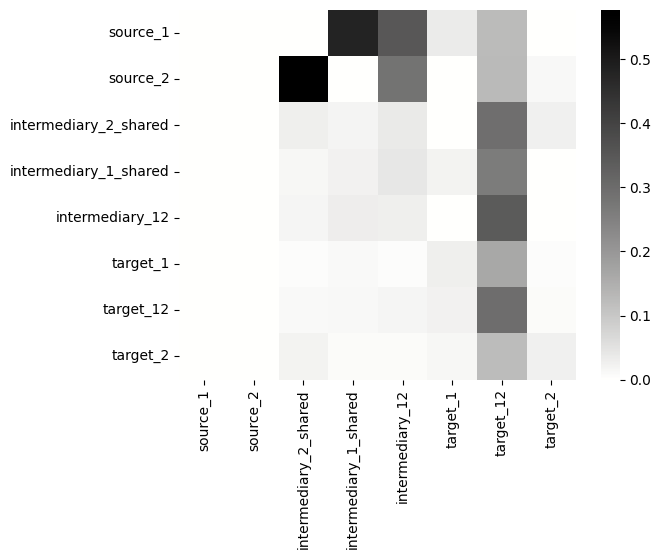

In [29]:
# Plot connectivity matrix
cmap = cmocean.cm.gray_r
sns.heatmap(conn_mat_group_fractional_outputs, 
            xticklabels = groups, 
            yticklabels = groups,
            cmap = cmap)
#plt.savefig(r"C:\Users\Chris\Desktop\connectivity_matrix.eps", transparent=True)
plt.show()

In [30]:
# Display number of neurons per group 
groups = df_indices.group.unique().tolist()
for group in groups:
    n = len(df_indices[df_indices["group"]==group])
    print(group + ': ' + str(n))

source_1: 1
source_2: 1
intermediary_2_shared: 28
intermediary_1_shared: 31
intermediary_12: 22
target_1: 51
target_12: 261
target_2: 55


In [31]:
# Calculate output of neurons in specific group 
pre_index = groups.index("source_1")
post_index = groups.index("intermediary_12") 
np.sum(conn_mat_group_fractional_outputs[pre_index,post_index]) 

np.float64(0.3504366812227073)

In [32]:
def plot_list_profile(input_list, sort_list):

    # Get unique list elements
    keys = list(Counter(input_list).keys())
    values = list(Counter(input_list).values())
    values_sum = np.sum(values)
    values = values/values_sum
    
    # Sort list elements
    sort_list = [sort_list[index] for index, key in enumerate(sort_list) if key in input_list]
    sort_index = [keys.index(key) for key in sort_list]
    keys = [keys[index] for index in sort_index]
    values = [values[index] for index in sort_index]
    
    # Generate dictionary for plotting
    plot_dict = {}
    for index, key in enumerate(keys):
        plot_dict[key] = values[index]
        
    # Plot stacked bar graph 
    fig, ax = plt.subplots()
    width = 0.5   
    bottom = 0
    for key in plot_dict.keys():
        p = ax.bar(1, plot_dict[key], width, label=key, bottom=bottom)
        bottom += plot_dict[key]
    plt.xlim(0,2)
    ax.legend(loc="upper right")

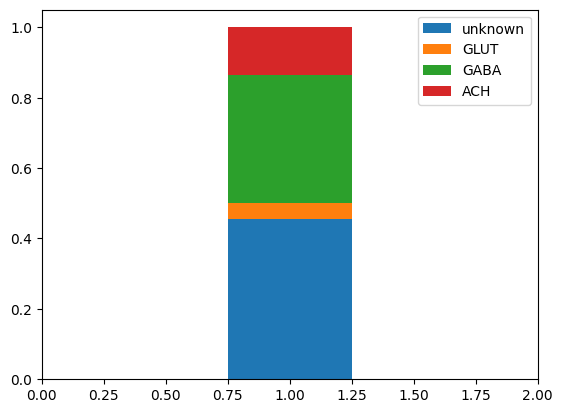

In [33]:
# Plot super class and neurotransmitter profile of specific group of neurons
group = "intermediary_12"

# Get root IDs of neurons in specific group
root_ids = df_indices.root_id[df_indices["group"]==group].tolist()

# Get super classes and neurotransmitters
super_class = []
nt_types = []
for root_id in root_ids:
    super_class.append(df_class.super_class[df_class.root_id==root_id].item())
    nt_types.append(df_indices.nt_type[df_indices.root_id==root_id].item())

# Plot super class profile
#plot_list_profile(super_class, ['visual_centrifugal','ascending','central'])

# Plot neurotransmitter profile
plot_list_profile(nt_types, ['unknown','DA','OCT','GLUT','GABA','ACH'])

In [34]:
# Generate connectivity matrix with input fractions
conn_mat_fractional_inputs = np.zeros((len(nodes),len(nodes)))
for index_post_node, node in enumerate(nodes):
    # Get total number of input synapses of node 
    n_inputs = df_connectivity.syn_count[(df_connectivity['post_root_id'] == node)].sum()
    
    # Get presynaptic connectivity of node in trimmed dataframe
    df = df_connectivity_trimmed[(df_connectivity_trimmed['post_root_id'] == node)]
    
    for row_index, row in df.iterrows():
        syn_count = row["syn_count"]
        pre_node = row["pre_root_id"]
        index_pre_node = nodes.index(pre_node)
        
        conn_mat_fractional_inputs[index_pre_node,index_post_node] += syn_count/n_inputs

In [35]:
# Trim connectivity matrix to shared pathways and add inhibitory effect

if source_neurons == 'RR':
    sub_classes = df_indices.sub_class.unique().tolist()

elif source_neurons == 'RR_BPN':
    # For RR vs BPN, select only shared pathways
    sub_classes = ["source_1", 
                   "source_2", 
                   "intermediary_12", 
                   "intermediary_1_shared", 
                   "intermediary_2_shared", 
                   "target_12"]

conn_mat_shared = conn_mat_fractional_inputs.copy()
indices_to_keep = []

for index in range(len(df_indices)):
    sub_class = df_indices.sub_class[index]
    nt_type = df_indices.nt_type[index]
    
    if sub_class in sub_classes:
        indices_to_keep.append(index)      
    
    # Set outputs of neurons with unknown neurotransmitter to zero. 
    # Note that only intermediary neurons with a prediction score smaller nt_score_thresh are set to 'unknown' above.
    if nt_type == 'unknown':
        conn_mat_shared[index,:] = conn_mat_shared[index,:]*0
    
    # Make inhibitory connections negative
    if nt_type in nt_inhibitory_effect:
        conn_mat_shared[index,:] = conn_mat_shared[index,:]*-1
    
# Trim matrix 
conn_mat_shared = conn_mat_shared[np.array(indices_to_keep),:][:,np.array(indices_to_keep)]

In [36]:
# Generate new version of df_indices for conn_mat_shared
df_indices_shared = df_indices[df_indices["matrix_index"].isin(indices_to_keep)]
df_indices_shared["matrix_index"] = indices_to_keep
df_indices_shared = df_indices_shared.reset_index(drop=True)
df_indices_shared

,matrix_index,root_id,nt_type,nt_type_score,super_class,sub_class,group
0,0,720575940639781027,ACH,0.79,source,source_1,source_1
1,1,720575940633362145,ACH,0.83,source,source_2,source_2
2,2,720575940603235500,unknown,0.55,intermediary,intermediary_2_shared,intermediary_2_shared
3,3,720575940604458668,ACH,0.87,intermediary,intermediary_1_shared,intermediary_1_shared
4,4,720575940605218220,GLUT,0.62,intermediary,intermediary_1_shared,intermediary_1_shared
...,...,...,...,...,...,...,...
445,445,720575940647586948,ACH,0.91,target,target_12,target_12
446,446,720575940648636292,GLUT,0.60,target,target_1,target_1
447,447,720575940650929273,DA,0.54,target,target_12,target_12
448,448,720575940653310198,GLUT,0.88,target,target_2,target_2


In [37]:
# Compute connectivity strength
conn_mat_shared_one_hop = conn_mat_shared.copy() 
conn_mat_shared_two_hops = np.matmul(conn_mat_shared_one_hop, conn_mat_shared_one_hop)
conn_mat_shared_one_two_hops = conn_mat_shared_one_hop + conn_mat_shared_two_hops

In [38]:
def sort_nodes(conn_mat,source_indices,target_indices):
    
    conn_strength = conn_mat[source_indices[0],target_indices]
    for index, source_index in enumerate(source_indices):
        if index>0:
            conn_strength += conn_mat[source_index,target_indices]
    
    target_indices_sorted = (-conn_strength).argsort()  
    conn_strength_sorted = conn_strength[target_indices_sorted]
    
    return target_indices_sorted, conn_strength_sorted

In [39]:
# Build dataframe with target nodes ranked based on connectivity strength
if source_neurons == 'RR':
    target_indices = df_indices_shared.index[df_indices_shared["super_class"] == "target"].tolist()
    target_ids = df_indices_shared.root_id[df_indices_shared["super_class"] == "target"].tolist()
    
elif source_neurons == 'RR_BPN':
    # For RR vs BPN, select only shared targets
    target_indices = df_indices_shared.index[df_indices_shared["sub_class"] == "target_12"].tolist()
    target_ids = df_indices_shared.root_id[df_indices_shared["sub_class"] == "target_12"].tolist()


# Rank target nodes based on combined connectivity strength from source_1 and source_2
source_indices = df_indices_shared.index[df_indices_shared["sub_class"].isin(["source_1","source_2"])].tolist()
target_indices_sorted, conn_strength_sorted = sort_nodes(conn_mat_shared_one_two_hops, source_indices, target_indices)
target_ids_sorted = [target_ids[index] for index in target_indices_sorted]

# Rank target nodes based on connectivity strength from source_1
source_indices = df_indices_shared.index[df_indices_shared["sub_class"].isin(["source_1"])].tolist()
target_indices_sorted_source_1, conn_strength_sorted_source_1 = sort_nodes(conn_mat_shared_one_two_hops, source_indices, target_indices)

# Rank target nodes based on connectivity strength from source_2
source_indices = df_indices_shared.index[df_indices_shared["sub_class"].isin(["source_2"])].tolist()
target_indices_sorted_source_2, conn_strength_sorted_source_2 = sort_nodes(conn_mat_shared_one_two_hops, source_indices, target_indices)


# Build dataframe
df_targets_ranked = pd.DataFrame()
df_targets_ranked['root_id'] = target_ids_sorted

df_targets_ranked['rank_source_12'] = np.linspace(1, len(target_ids_sorted), len(target_ids_sorted)).astype(int)
df_targets_ranked['conn_strength_source_12'] = conn_strength_sorted

map_index = [np.argwhere(target_indices_sorted_source_1 == index)[0][0] for index in target_indices_sorted]
df_targets_ranked['rank_source_1'] = map_index
df_targets_ranked['rank_source_1'] += 1
df_targets_ranked['conn_strength_source_1'] = conn_strength_sorted_source_1[map_index] 

map_index = [np.argwhere(target_indices_sorted_source_2 == index)[0][0] for index in target_indices_sorted]
df_targets_ranked['rank_source_2'] = map_index
df_targets_ranked['rank_source_2'] += 1
df_targets_ranked['conn_strength_source_2'] = conn_strength_sorted_source_2[map_index]

In [40]:
# Add relative input from shared circuit neurons
syn_count_shared_rel = []

pre_ids = df_indices_shared.root_id[df_indices_shared.group.isin(['source_1','source_2','intermediary_12','intermediary_1_shared','intermediary_2_shared'])].tolist()
target_ids = df_targets_ranked.root_id.tolist()
for target_id in target_ids:
    syn_count_total = df_connectivity.syn_count[df_connectivity.post_root_id==target_id].sum().item()
    syn_count_shared = df_connectivity.syn_count[(df_connectivity.post_root_id==target_id) & (df_connectivity.pre_root_id.isin(pre_ids))].sum().item()
    syn_count_shared_rel.append(syn_count_shared/syn_count_total)

df_targets_ranked['syn_count_shared_rel'] = syn_count_shared_rel

In [41]:
df_targets_ranked

,root_id,rank_source_12,conn_strength_source_12,rank_source_1,conn_strength_source_1,rank_source_2,conn_strength_source_2,syn_count_shared_rel
0,720575940625513360,1,0.016476,1,0.016308,50,0.000168,0.084665
1,720575940616886301,2,0.015017,18,0.000594,1,0.014423,0.152610
2,720575940617952034,3,0.011400,2,0.011400,199,0.000000,0.025777
3,720575940609376707,4,0.010515,3,0.005031,4,0.005484,0.065311
4,720575940627732423,5,0.008865,215,0.000000,2,0.008865,0.008865
...,...,...,...,...,...,...,...,...
362,720575940610472146,363,-0.002272,160,0.000008,366,-0.002280,0.114680
363,720575940639428174,364,-0.002384,367,-0.002155,347,-0.000229,0.230841
364,720575940634560922,365,-0.002604,364,-0.001434,362,-0.001170,0.128082
365,720575940640747352,366,-0.002610,363,-0.001070,365,-0.001540,0.105263


In [42]:
# Plot relative input from the shared circuit onto specific descending neurons
if source_neurons == 'RR_BPN':
    cell_types = ["DNg101", "DNg102", "DNpe020", "DNge103", "DNge050", "DNg44", "DNd05", "DNge048", "DNg45", "DNge082", 
                  "DNge150", "DNp68", "DNpe053", "DNp13", "DNp64", "DNp52", "DNpe042", "DNg55", "DNge053", "DNge138"]

    # Loop over cell types
    syn_count_shared_rel = []
    for cell_type in cell_types:
        root_ids = df_neurons_of_interest.root_id[df_neurons_of_interest.cell_type == cell_type].tolist()
        syn_count_shared_rel.append(df_targets_ranked.syn_count_shared_rel[df_targets_ranked.root_id.isin(root_ids)].mean().tolist())

    # Plot
    cmap = cmocean.cm.gray_r
    plt.figure(figsize=(6, 1))

    sns.heatmap([syn_count_shared_rel],
                cmap = cmap, 
                vmin = 0, 
                vmax = 0.4)
    #plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
    plt.show()

BDN4 walking initiation
MDN walking backward
BDN4 walking initiation
MDN walking backward
MDN walking backward
BDN1 walking initiation
MDN walking backward
DNg13 walking turning
oDN1 walking initiation
oDN1 walking initiation
DNb08 walking initiation
DNb08 walking initiation
DNg13 walking turning
DNa01 walking turning
DNb08 walking initiation
BDN2 walking initiation, speed
DNb08 walking initiation
DNa01 walking turning
BDN2 walking initiation, speed
DNa03 walking, flight turning
DNa03 walking, flight turning
cDN1 walking initiation
DNb01 flight turning
DNb01 flight turning
DNa02 walking turning
DNb05 walking turning
DNa02 walking turning
cDN1 walking initiation
DNg02 flight speed
DNg02 flight speed
Bluebell walking halting
DNp09 walking turning
DNp09 walking turning
Bluebell walking halting
BDN3 walking initiation
DNa11 walking, flight turning
BDN1 walking initiation
DNa11 walking, flight turning


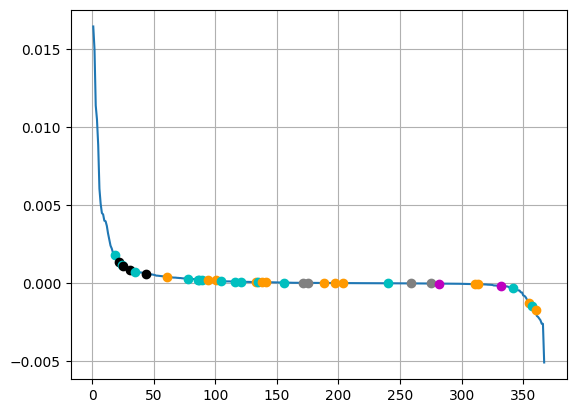

In [43]:
# Plot net excitation onto target nodes 
plt.plot(df_targets_ranked.rank_source_12, df_targets_ranked.conn_strength_source_12)

target_ids = df_targets_ranked.root_id.tolist()
ids_of_interest = df_neurons_of_interest.root_id.tolist()
for index, target_id in enumerate(target_ids):
    if target_id in ids_of_interest:
        name = df_neurons_of_interest.community_name[df_neurons_of_interest.root_id == target_id].item()       
        motor_program = df_neurons_of_interest.motor_program[df_neurons_of_interest.root_id == target_id].item()
        motor_function = df_neurons_of_interest.motor_function[df_neurons_of_interest.root_id == target_id].item()
        if not pd.isnull(motor_function):
            print(name + ' ' + motor_program + ' ' + motor_function)
            if ('walking' in motor_program) & ('initiation' in motor_function):
                color = [0,191/255,191/255]
            elif ('walking' in motor_program) & ('turning' in motor_function):
                color = [1,153/255,0]    
            elif ('walking' in motor_program) & ('halting' in motor_function):
                color = [191/255,0,191/255]
            elif ('walking' in motor_program) & ('backward' in motor_function):
                color = [0,0,0]
            elif 'flight' in motor_program:
                color = [.5,.5,.5]
            else:
                color = [1,0,0]
            plt.plot(index+1, df_targets_ranked.conn_strength_source_12[df_targets_ranked.root_id == target_id], 'o', color=color)

plt.grid()
# plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
plt.show()

In [44]:
## Plot net excitation onto target nodes per source 
#ranks_to_highlight = [1] #,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
##ids_to_highlight = [720575940621068464, 720575940642549467, 720575940630334658, 720575940634459290]
#
#plt.plot(df_targets_ranked.conn_strength_source_1, df_targets_ranked.conn_strength_source_2, 'ok')
#
#plt.plot(df_targets_ranked.conn_strength_source_1[df_targets_ranked.rank_source_12.isin(ranks_to_highlight)], 
#         df_targets_ranked.conn_strength_source_2[df_targets_ranked.rank_source_12.isin(ranks_to_highlight)], 
#         'og')
##plt.plot(df_targets_ranked.conn_strength_source_1[df_targets_ranked.root_id.isin(ids_to_highlight)], 
##         df_targets_ranked.conn_strength_source_2[df_targets_ranked.root_id.isin(ids_to_highlight)], 
##         'og')
#
#plt.grid()
#plt.xlim([-0.01,0.02])
#plt.ylim([-0.01,0.055])
##plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
#plt.show()
#
#df_class[df_class.root_id == df_targets_ranked.root_id[df_targets_ranked.rank_source_12.isin(ranks_to_highlight)].item()]
##print(df_targets_ranked.conn_strength_source_1[df_targets_ranked.root_id.isin(ids_to_highlight)].item())
##print(df_targets_ranked.conn_strength_source_2[df_targets_ranked.root_id.isin(ids_to_highlight)].item())

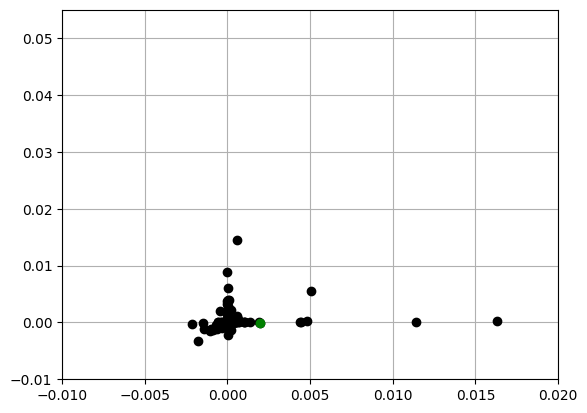

,root_id,flow,super_class,class,sub_class,hemilineage,side,nerve
91021,720575940628858640,efferent,descending,NaN,NaN,VLPl&p2_posterior,right,CV


In [45]:
# Plot net excitation onto target nodes per source 
ranks_to_highlight = [17] #,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
#ids_to_highlight = [720575940621068464, 720575940642549467, 720575940630334658, 720575940634459290]

plt.plot(df_targets_ranked.conn_strength_source_1, df_targets_ranked.conn_strength_source_2, 'ok')

plt.plot(df_targets_ranked.conn_strength_source_1[df_targets_ranked.rank_source_12.isin(ranks_to_highlight)], 
         df_targets_ranked.conn_strength_source_2[df_targets_ranked.rank_source_12.isin(ranks_to_highlight)], 
         'og')
#plt.plot(df_targets_ranked.conn_strength_source_1[df_targets_ranked.root_id.isin(ids_to_highlight)], 
#         df_targets_ranked.conn_strength_source_2[df_targets_ranked.root_id.isin(ids_to_highlight)], 
#         'og')

plt.grid()
plt.xlim([-0.01,0.02])
plt.ylim([-0.01,0.055])
#plt.savefig(r"C:\Users\Chris\Desktop\figure.eps", transparent=True)
plt.show()

df_class[df_class.root_id == df_targets_ranked.root_id[df_targets_ranked.rank_source_12.isin(ranks_to_highlight)].item()]
#print(df_targets_ranked.conn_strength_source_1[df_targets_ranked.root_id.isin(ids_to_highlight)].item())
#print(df_targets_ranked.conn_strength_source_2[df_targets_ranked.root_id.isin(ids_to_highlight)].item())

In [46]:
df_targets_ranked

,root_id,rank_source_12,conn_strength_source_12,rank_source_1,conn_strength_source_1,rank_source_2,conn_strength_source_2,syn_count_shared_rel
0,720575940625513360,1,0.016476,1,0.016308,50,0.000168,0.084665
1,720575940616886301,2,0.015017,18,0.000594,1,0.014423,0.152610
2,720575940617952034,3,0.011400,2,0.011400,199,0.000000,0.025777
3,720575940609376707,4,0.010515,3,0.005031,4,0.005484,0.065311
4,720575940627732423,5,0.008865,215,0.000000,2,0.008865,0.008865
...,...,...,...,...,...,...,...,...
362,720575940610472146,363,-0.002272,160,0.000008,366,-0.002280,0.114680
363,720575940639428174,364,-0.002384,367,-0.002155,347,-0.000229,0.230841
364,720575940634560922,365,-0.002604,364,-0.001434,362,-0.001170,0.128082
365,720575940640747352,366,-0.002610,363,-0.001070,365,-0.001540,0.105263


In [47]:
# Find target neurons on specific axes

# RR axis
df_temp = df_targets_ranked.sort_values(by='conn_strength_source_1', ascending=False)
df_temp = df_temp[(df_temp.conn_strength_source_1>0.002) & (df_temp.conn_strength_source_2<0.005)]

# BPN axis
#df_temp = df_targets_ranked.sort_values(by='conn_strength_source_2', ascending=False)
#df_temp = df_temp[(df_temp.conn_strength_source_2>0.01) & (df_temp.conn_strength_source_1<0.001)]

# RR-BPN axis
#df_temp = df_targets_ranked
#df_temp = df_temp[(df_temp.conn_strength_source_1>0.001) & (df_temp.conn_strength_source_2>0.005)]

df_temp

,root_id,rank_source_12,conn_strength_source_12,rank_source_1,conn_strength_source_1,rank_source_2,conn_strength_source_2,syn_count_shared_rel
0,720575940625513360,1,0.016476,1,0.016308,50,0.000168,0.084665
2,720575940617952034,3,0.011400,2,0.011400,199,0.000000,0.025777
6,720575940619038493,7,0.005089,4,0.004800,38,0.000289,0.075351
7,720575940614089726,8,0.004502,5,0.004461,94,0.000041,0.034483
8,720575940625295339,9,0.004410,6,0.004371,97,0.000040,0.057594


In [70]:
# Find top ten target neurons of a source
df_temp = df_targets_ranked.sort_values(by='conn_strength_source_1', ascending=False)
df_temp = df_temp[df_temp.rank_source_1<11]
df_temp

,root_id,rank_source_12,conn_strength_source_12,rank_source_1,conn_strength_source_1,rank_source_2,conn_strength_source_2,syn_count_shared_rel
0,720575940625513360,1,0.016476,1,0.016308,50,0.000168,0.084665
2,720575940617952034,3,0.011400,2,0.011400,199,0.000000,0.025777
3,720575940609376707,4,0.010515,3,0.005031,4,0.005484,0.065311
6,720575940619038493,7,0.005089,4,0.004800,38,0.000289,0.075351
7,720575940614089726,8,0.004502,5,0.004461,94,0.000041,0.034483
8,720575940625295339,9,0.004410,6,0.004371,97,0.000040,0.057594
16,720575940628858640,17,0.001955,7,0.001990,306,-0.000034,0.017990
17,720575940617280657,18,0.001914,8,0.001914,198,0.000000,0.060010
21,720575940640331472,22,0.001365,9,0.001365,149,0.000000,0.019600
25,720575940630480348,26,0.001089,10,0.001089,190,0.000000,0.022566
